# Formalization of prediction about transition rate decodability

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import sys
from sklearn.linear_model import Ridge
from my_stats import get_r2

from disp import set_plot

DT = .001
T = 20
NT = int(T/DT)

TAU_ETA = .05
TH = np.arange(0, 4*TAU_ETA, DT)
H_ETA = np.exp(-TH/TAU_ETA)/TAU_ETA

F_MAX = 30
NTAU_TR = 50
TAU_TR = np.logspace(-1, 1.5, NTAU_TR)

N = 50
TAU_R = np.logspace(-1, 1.5, N)

### Create stimuli with varied transition rates

In [2]:
t = np.arange(NT)*DT

NRTR = 10
RTR = np.linspace(.1, 30, NRTR)

NRPT_PER_RTR = 10

trs = np.zeros((NRPT_PER_RTR*NRTR, NT))
i_ins = np.nan*np.zeros(trs.shape)

c = 0
for rtr in RTR:
    for cstim in range(NRPT_PER_RTR):
        trs[c, 1:] = np.random.rand(NT-1) < rtr*DT
        i_ins[c, :] = np.cumsum(trs[c, :]) % 2
        
        c += 1
        
NRPT = NRTR*NRPT_PER_RTR

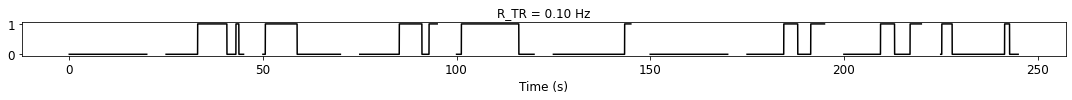

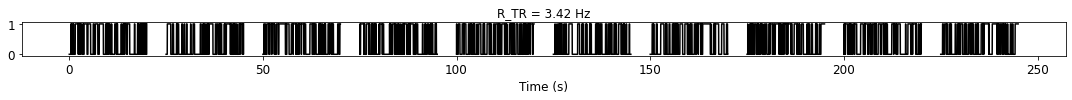

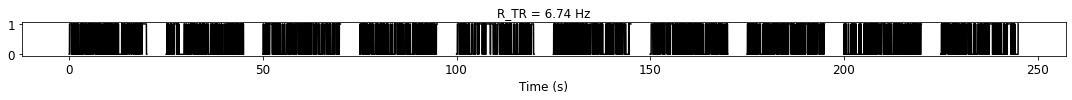

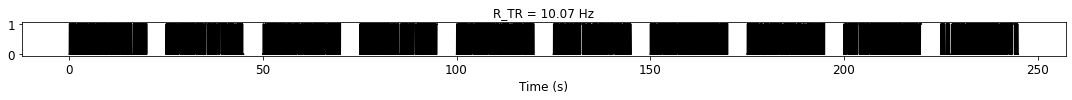

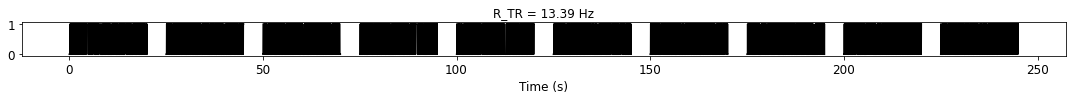

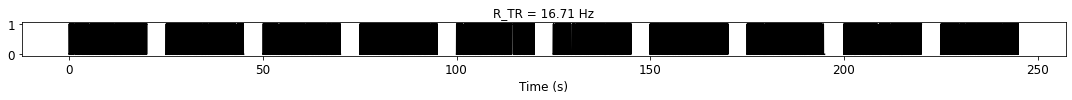

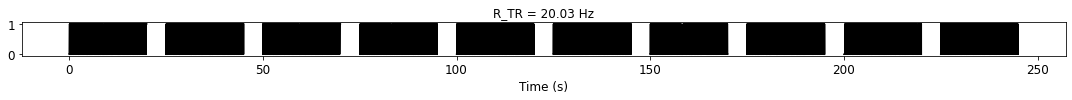

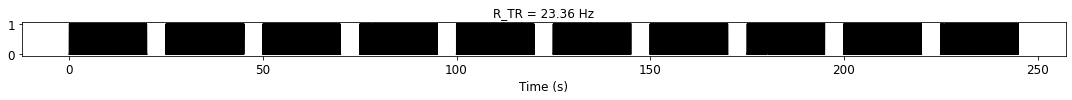

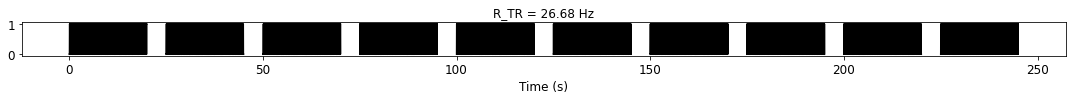

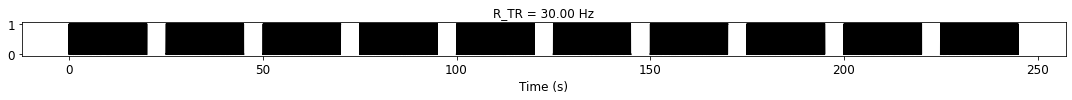

In [3]:
for crtr, rtr in enumerate(RTR):
    fig, ax = plt.subplots(1, 1, figsize=(15, 1.5), tight_layout=True)
    for crpt in range(NRPT_PER_RTR):
        ii = crtr*NRPT_PER_RTR + crpt
        t_offset = 1.25*T*crpt
        
        ax.plot(t + t_offset, i_ins[ii, :], c='k')
        
    set_plot(ax, x_label='Time (s)', title=f'R_TR = {rtr:.2f} Hz', font_size=12)

In [8]:
# get estimate rates at end of each repeat
r_tr_ests = np.nan * np.zeros((NRPT, len(TAU_TR)))

for ctr, tr in enumerate(trs):
    temp = np.zeros(len(TAU_TR))
    for ct in range(1, NT):
        temp = temp + DT/TAU_TR*(-temp + tr[ct])
    
    r_tr_ests[ctr] = temp
    
r_tr_ests /= DT

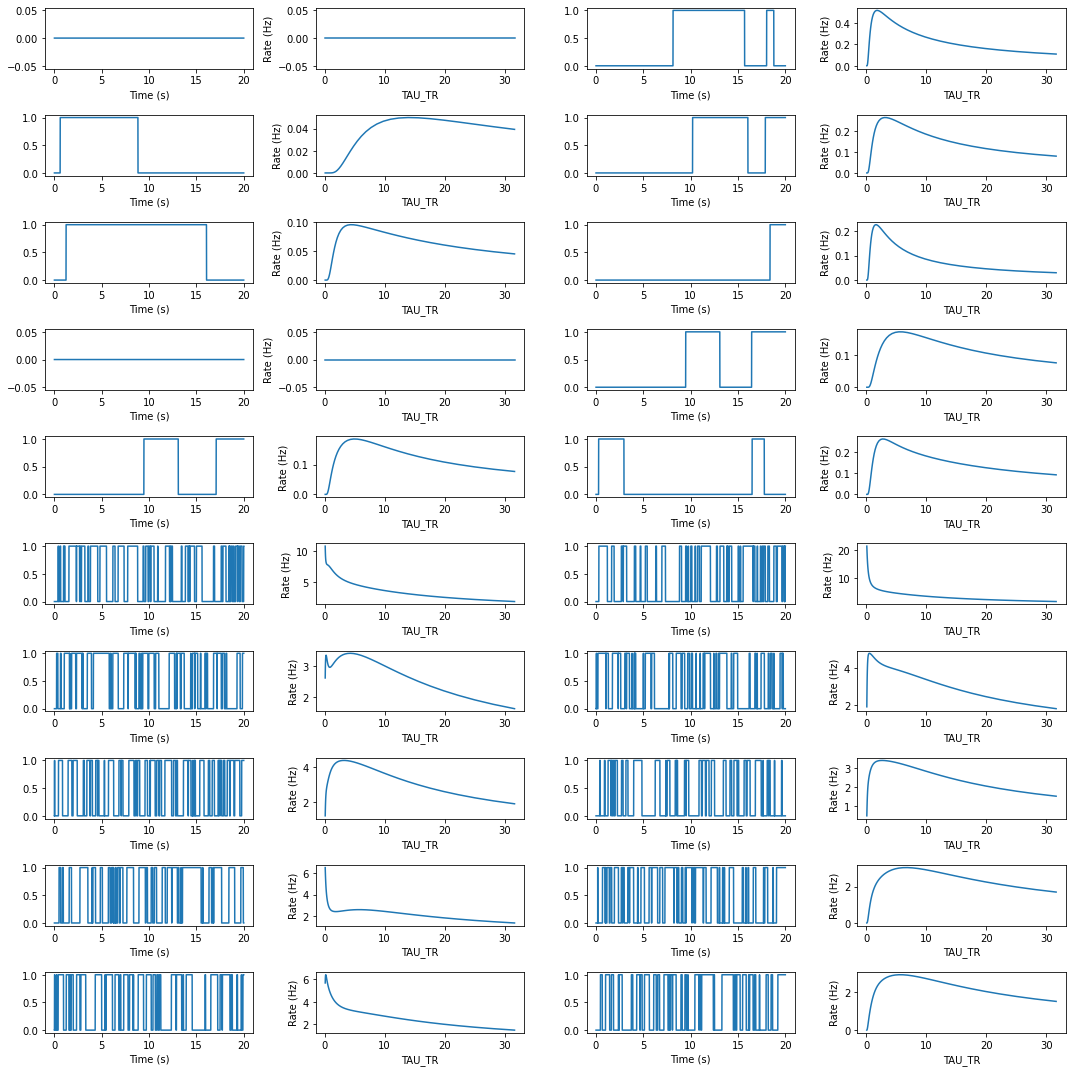

In [10]:
fig, axs = plt.subplots(10, 4, figsize=(15, 15), tight_layout=True)
axs = axs.flatten()

for crpt in range(len(axs)//2):
    axs[2*crpt].plot(t, i_ins[crpt, :])
    axs[2*crpt].set_xlabel('Time (s)')
    
    axs[2*crpt+1].plot(TAU_TR, r_tr_ests[crpt])
    axs[2*crpt+1].set_xlabel('TAU_TR')
    axs[2*crpt+1].set_ylabel('Rate (Hz)')

### Linear neural response

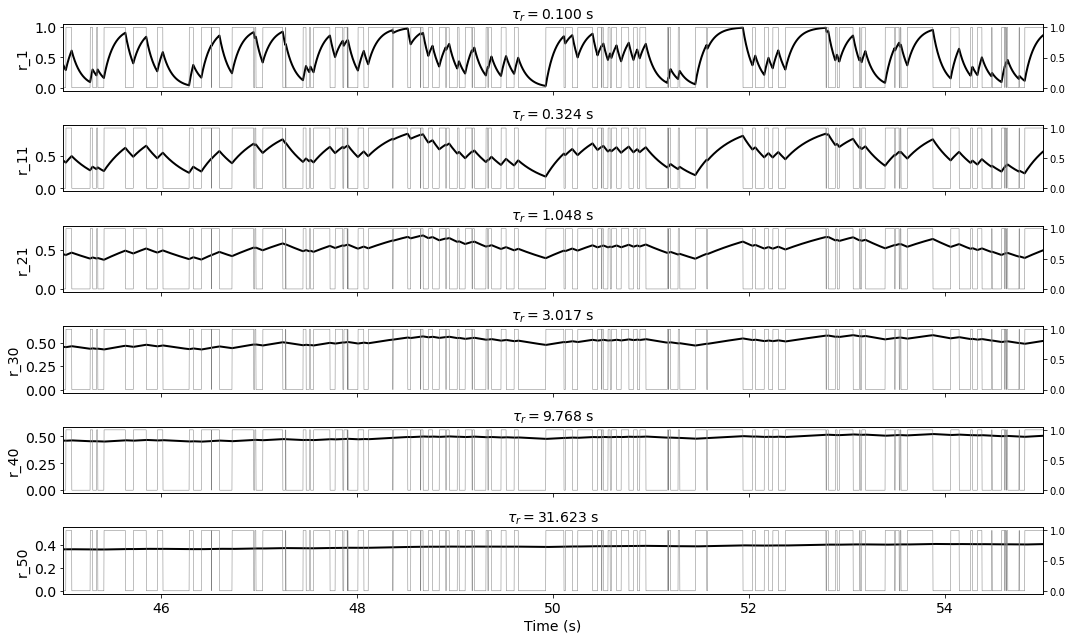

In [17]:
r_lin = np.nan*np.zeros((NRPT, N))

for crpt, i_in in enumerate(i_ins):
    
    r_temp = np.zeros(N)
    
    for ct in range(1, NT):
        r_temp = r_temp + DT/TAU_R*(-temp + i_in[ct])
    
    r_lin[crpt, :] = r_temp.copy()
    
nr_plot = 6
fig, axs = plt.subplots(nr_plot, 1, figsize=(15, 9), sharex=True, tight_layout=True)
idxs_plot = np.round(np.linspace(0, N-1, nr_plot)).astype(int)

for idx, ax in zip(idxs_plot, axs):
    ax.plot(t, r_lin[:, idx], c='k', lw=2)
    ax_twin = ax.twinx()
    ax_twin.plot(t, i, c='gray', lw=.5)
    
    if ax is axs[-1]:
        ax.set_xlabel('Time (s)')
        
    set_plot(ax, x_lim=x_lim, y_label=f'r_{idx+1}', title=(r'$\tau_r = $' + f'{TAU_R[idx]:.3f} s'), font_size=14)

### Multiplicative adaptation neural response

$$\tau_r \frac{dr}{dt} = -r + (1-a)I(t)$$

$$\tau_a \frac{da}{dt} = -a + I(t)$$

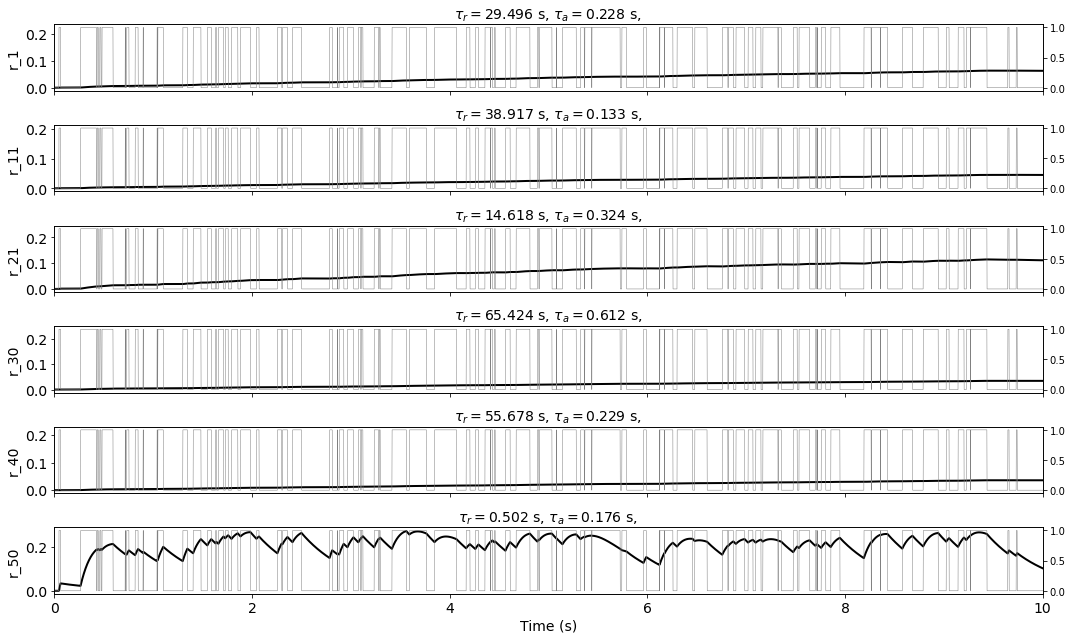

In [18]:
TAU_R_MA = np.clip(np.random.exponential(20, N), .1, np.inf)
TAU_A_MA = np.clip(np.random.exponential(1, N), .1, np.inf)

r_ma = np.nan*np.zeros((NT, N))
r_ma[0, :] = 0

a = np.zeros(N)

for ct in range(1, NT):
    r_ma[ct, :] = r_ma[ct-1, :] + DT/TAU_R_MA*(-r_ma[ct-1, :] + (1-a)*i[ct])
    a = a + DT/TAU_A_MA*(-a + i[ct])
    
nr_plot = 6
fig, axs = plt.subplots(nr_plot, 1, figsize=(15, 9), sharex=True, tight_layout=True)
idxs_plot = np.round(np.linspace(0, N-1, nr_plot)).astype(int)

x_lim = (0, 10)
for idx, ax in zip(idxs_plot, axs):
    ax.plot(t, r_ma[:, idx], c='k', lw=2)
    ax_twin = ax.twinx()
    ax_twin.plot(t, i, c='gray', lw=.5)
    
    if ax is axs[-1]:
        ax.set_xlabel('Time (s)')
        
    set_plot(ax, x_lim=x_lim, y_label=f'r_{idx+1}', title=(r'$\tau_r = $' + f'{TAU_R_MA[idx]:.3f} s, ' + r'$\tau_a = $' + f'{TAU_A_MA[idx]:.3f} s, '), font_size=14)

### Decode transition rate from linear response

..................................................

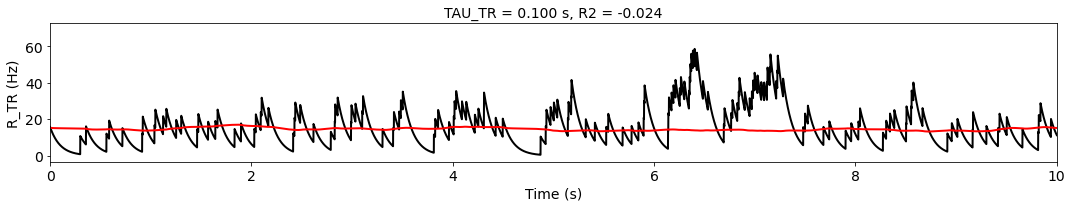

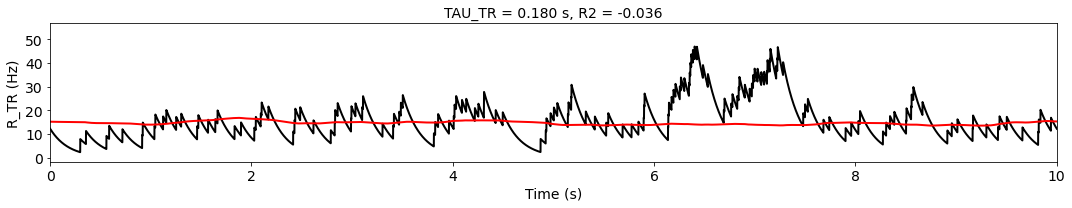

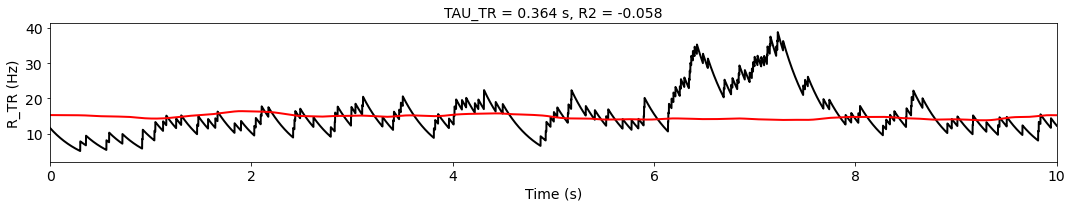

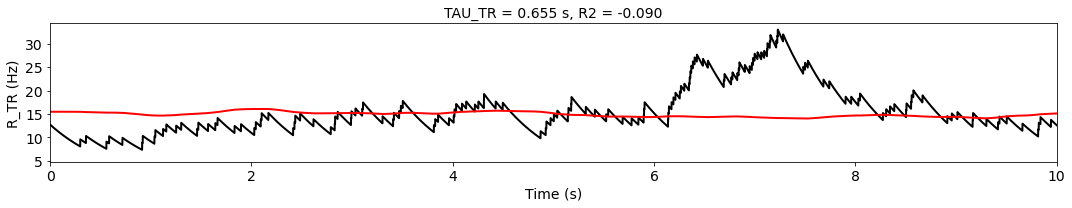

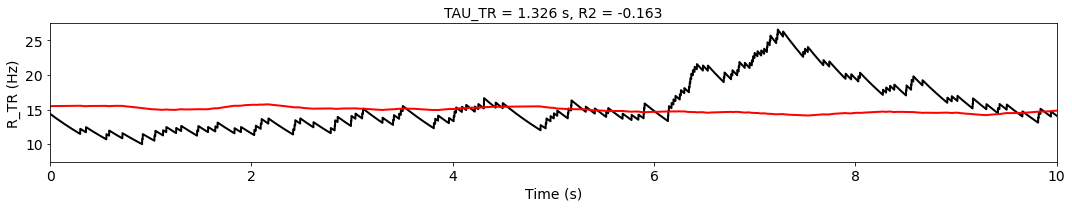

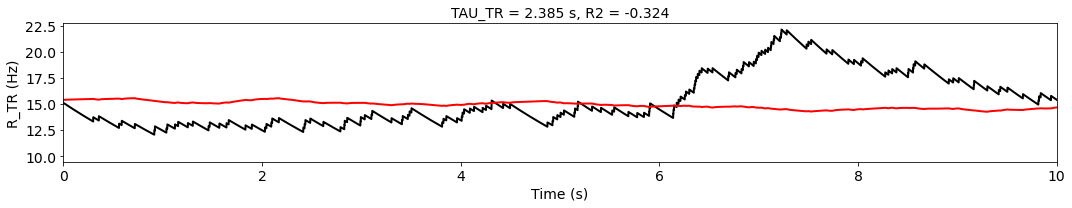

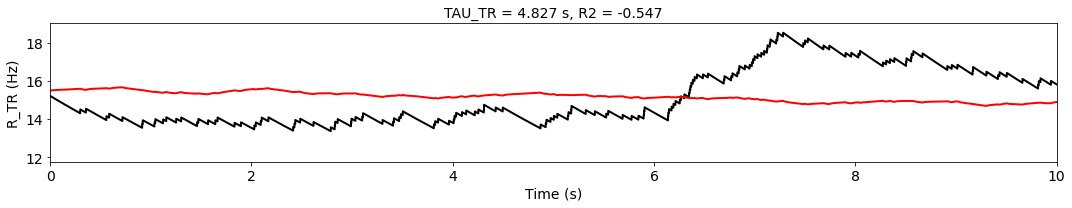

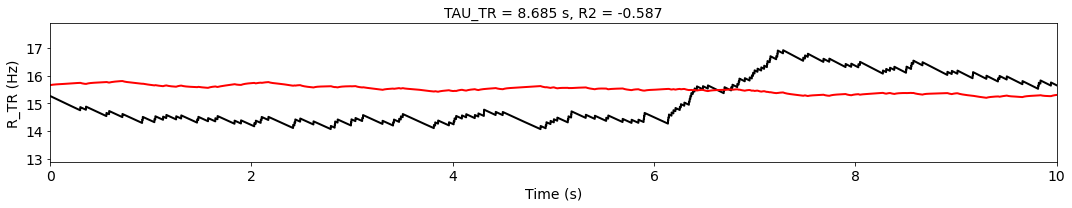

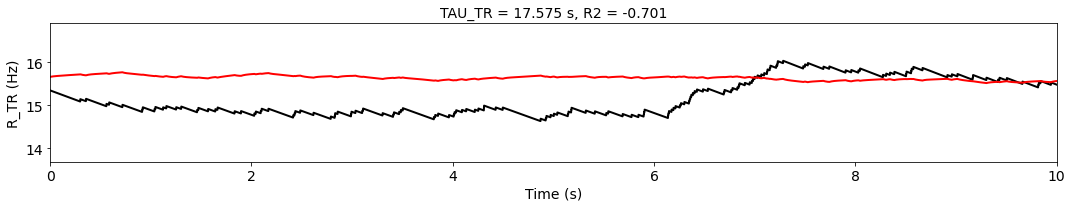

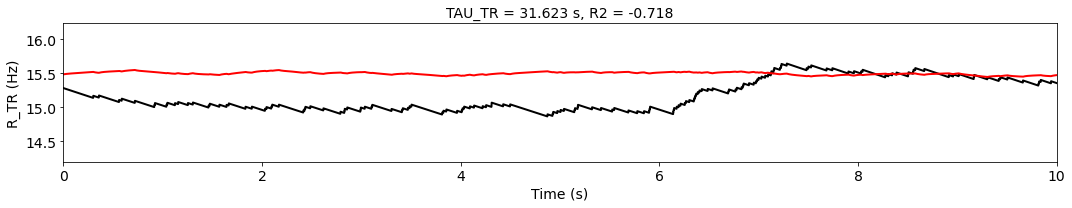

In [14]:

IT_TRAIN = (int(100/DT), int(250/DT))
IT_TEST = (int(250/DT), NT)

t_train = t[IT_TRAIN[0]:IT_TRAIN[1]]
t_test = t[IT_TEST[0]:IT_TEST[1]]

idxs_tau_tr_plot = np.round(np.linspace(0, NTAU_TR-1, 10)).astype(int)

for ctau_tr, tau_tr in enumerate(TAU_TR):
    sys.stdout.write('.')
    
    x_train = r_lin[IT_TRAIN[0]:IT_TRAIN[1], :]
    y_train = r_tr_est[IT_TRAIN[0]:IT_TRAIN[1]:, ctau_tr]
    
    rgr = Ridge(alpha=.0001).fit(x_train, y_train)
    
    y_hat_train = rgr.predict(x_train)
    r2_train = get_r2(y_train, y_hat_train)
    
    x_test = r_lin[IT_TEST[0]:IT_TEST[1], :]
    y_test = r_tr_est[IT_TEST[0]:IT_TEST[1]:, ctau_tr]
    
    y_hat_test = rgr.predict(x_test)
    r2_test = get_r2(y_test, y_hat_test)
    
    if ctau_tr in idxs_tau_tr_plot:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)
        ax.plot(t_test-t_test[0], y_test, c='k', lw=2)
        ax.plot(t_test-t_test[0], y_hat_test, c='r', lw=2)

        set_plot(ax, x_lim=x_lim, x_label='Time (s)', y_label=f'R_TR (Hz)', title=f'TAU_TR = {tau_tr:.3f} s, R2 = {r2_test:.3f}', font_size=14)

### Decode transition rate from MA response

..................................................

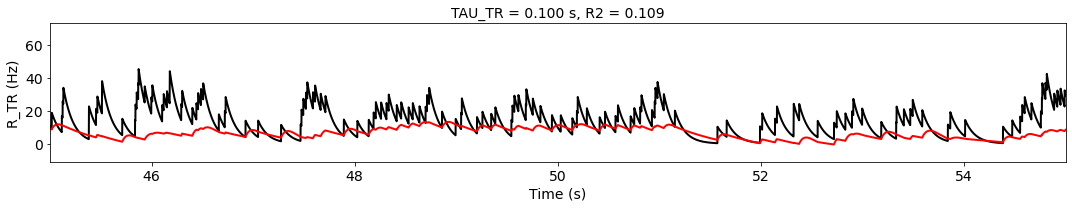

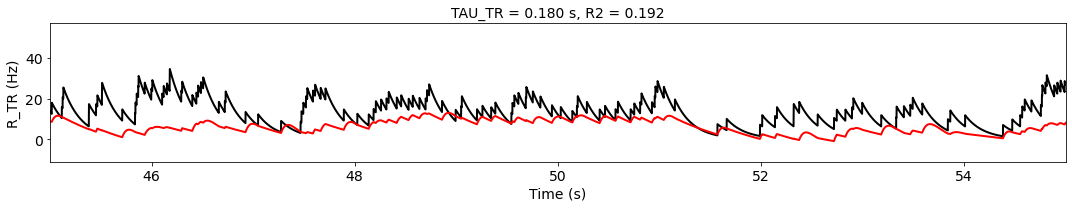

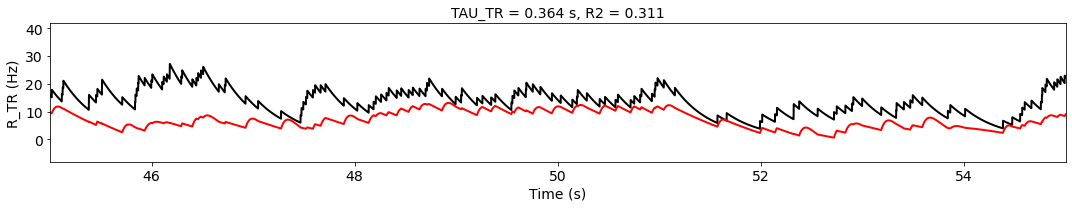

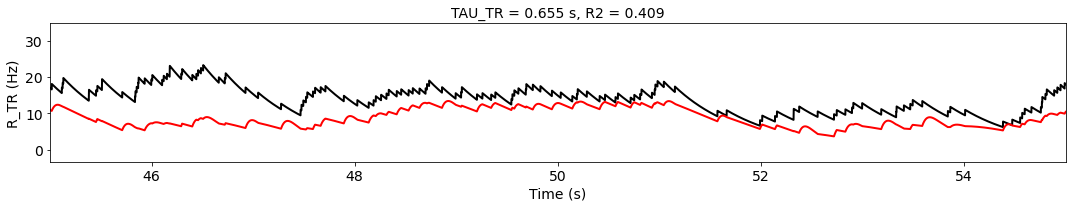

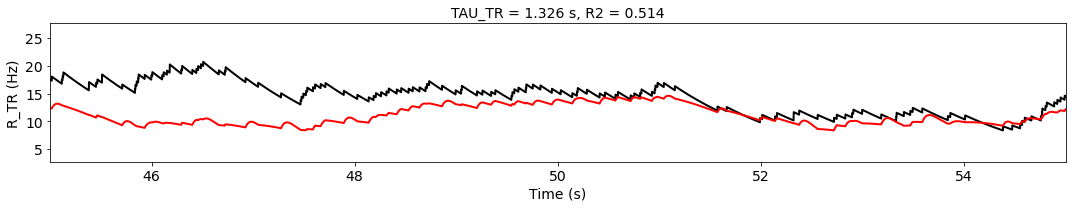

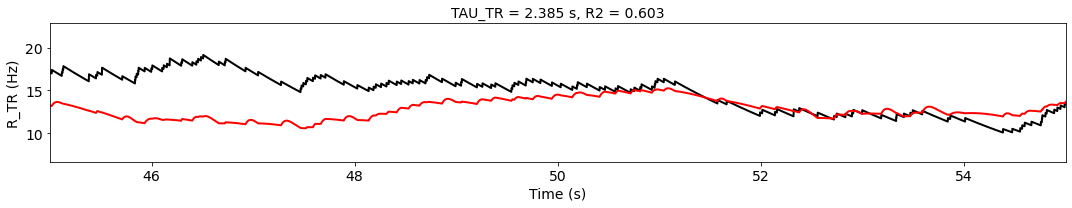

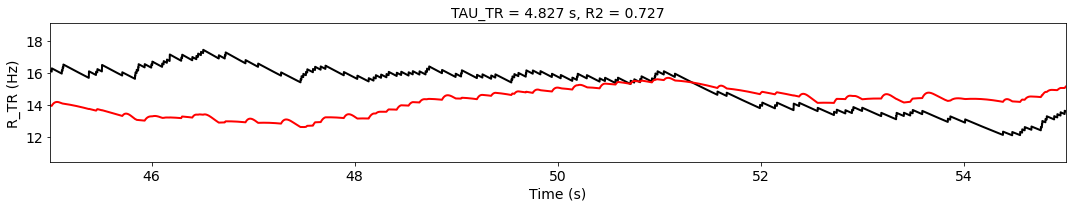

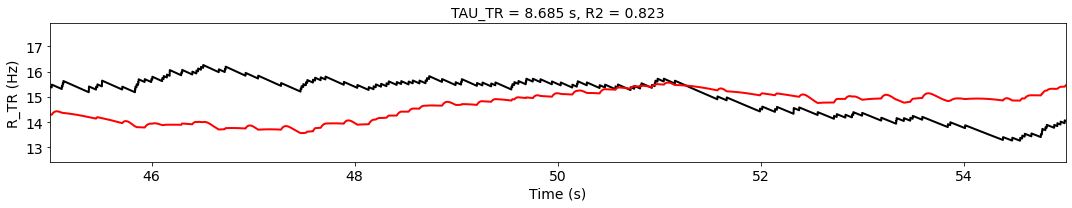

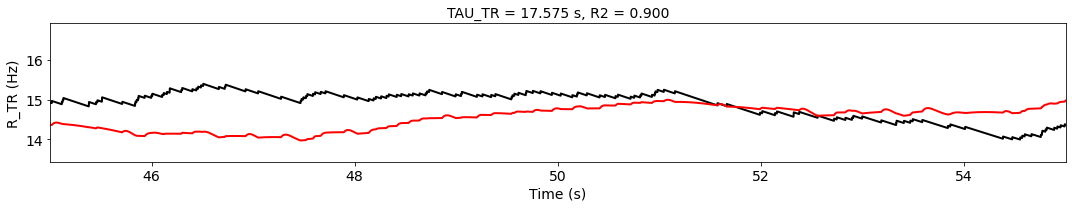

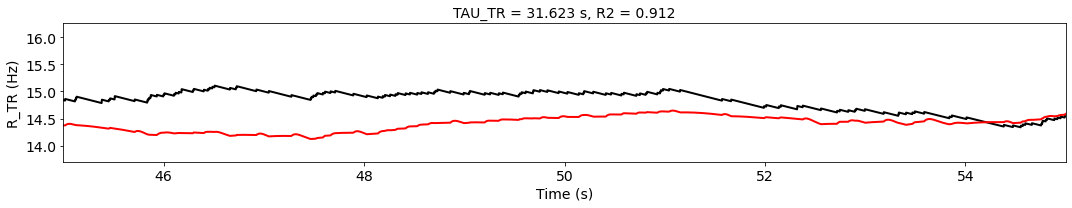

In [10]:
IT_TRAIN = (int(100/DT), int(250/DT))
IT_TEST = (int(250/DT), NT)

t_train = t[IT_TRAIN[0]:IT_TRAIN[1]]
t_test = t[IT_TEST[0]:IT_TEST[1]]

idxs_tau_tr_plot = np.round(np.linspace(0, NTAU_TR-1, 10)).astype(int)

for ctau_tr, tau_tr in enumerate(TAU_TR):
    sys.stdout.write('.')
    
    x_train = r_ma[IT_TRAIN[0]:IT_TRAIN[1], :]
    y_train = r_tr_est[IT_TRAIN[0]:IT_TRAIN[1]:, ctau_tr]
    
    rgr = Ridge(alpha=.0001).fit(x_train, y_train)
    
    y_hat_train = rgr.predict(x_train)
    r2_train = get_r2(y_train, y_hat_train)
    
    x_test = r_ma[IT_TEST[0]:IT_TEST[1], :]
    y_test = r_tr_est[IT_TEST[0]:IT_TEST[1]:, ctau_tr]
    
    y_hat_test = rgr.predict(x_test)
    r2_test = get_r2(y_test, y_hat_test)
    
    if ctau_tr in idxs_tau_tr_plot:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)
        ax.plot(t_test-t_test[0], y_test, c='k', lw=2)
        ax.plot(t_test-t_test[0], y_hat_test, c='r', lw=2)

        set_plot(ax, x_lim=x_lim, x_label='Time (s)', y_label=f'R_TR (Hz)', title=f'TAU_TR = {tau_tr:.3f} s, R2 = {r2_train:.3f}', font_size=14)

In [7]:
y_hat_test

array([14.80284915, 14.80266524, 14.80244107, ..., 14.3548051 ,
       14.35504802, 14.35530321])

## Doesn't work

### Chirpy input signal

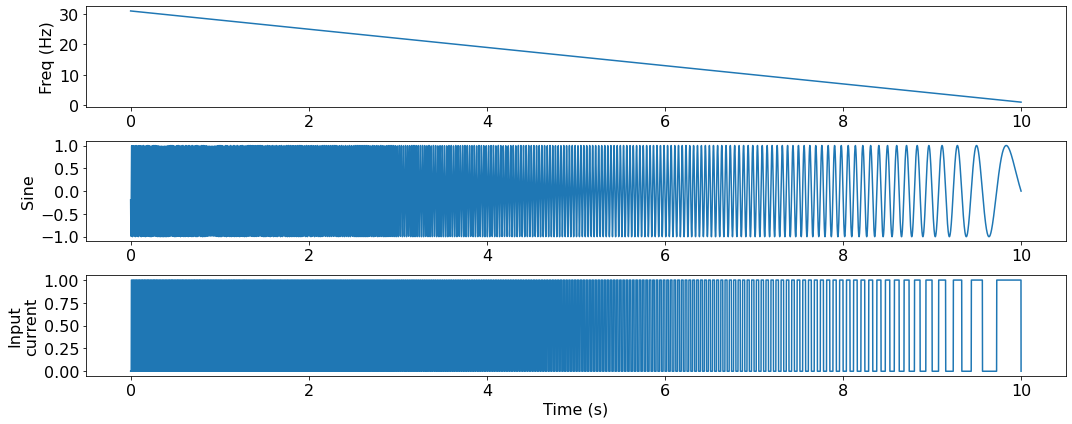

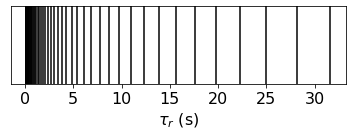

In [2]:
t = np.arange(NT)*DT
f = 1+np.linspace(0, 30, len(t))

osc = np.sin(2*np.pi*f*t)
i = (osc > 0).astype(float)

f = f[::-1]
osc = osc[::-1]
i = i[::-1]

fig, axs = plt.subplots(3, 1, figsize=(15, 6), tight_layout=True)
axs[0].plot(t, f)
axs[0].set_ylabel('Freq (Hz)')
axs[1].plot(t, osc)
axs[1].set_ylabel('Sine')
axs[2].plot(t, i)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Input\ncurrent')

for ax in axs:
    set_plot(ax, font_size=16)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 2), tight_layout=True)
for tau in TAU:
    ax.axvline(tau, c='k')
ax.yaxis.set_visible(False)
set_plot(ax, x_label=r'$\tau_r$ (s)', font_size=16)

### Linear neural response

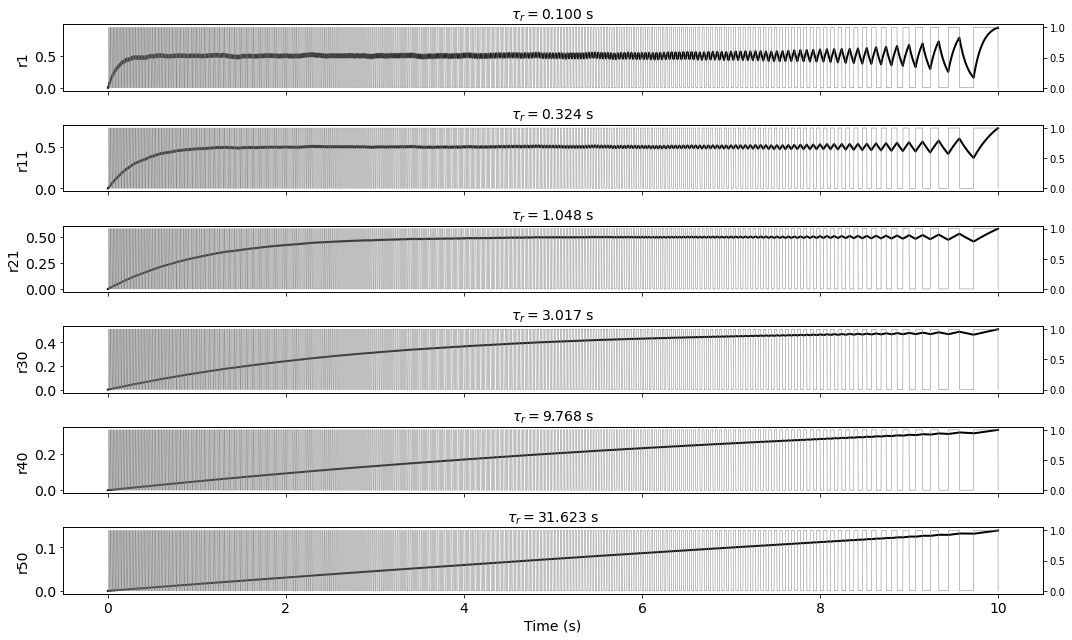

In [3]:
r_lin = np.nan*np.zeros((NT, N))
r_lin[0, :] = 0.

for ct in range(1, NT):
    r_lin[ct, :] = r_lin[ct-1, :] + DT/TAU*(-r_lin[ct-1, :] + i[ct])
    
nr_plot = 6
fig, axs = plt.subplots(nr_plot, 1, figsize=(15, 9), sharex=True, tight_layout=True)
idxs_plot = np.round(np.linspace(0, N-1, nr_plot)).astype(int)

for idx, ax in zip(idxs_plot, axs):
    ax.plot(t, r_lin[:, idx], c='k', lw=2)
    ax_twin = ax.twinx()
    ax_twin.plot(t, i, c='gray', lw=.5)
    
    if ax is axs[-1]:
        ax.set_xlabel('Time (s)')
    set_plot(ax, y_label=f'r{idx+1}', title=(r'$\tau_r = $' + f'{TAU[idx]:.3f} s'), font_size=14)
    

## Also doesn't work

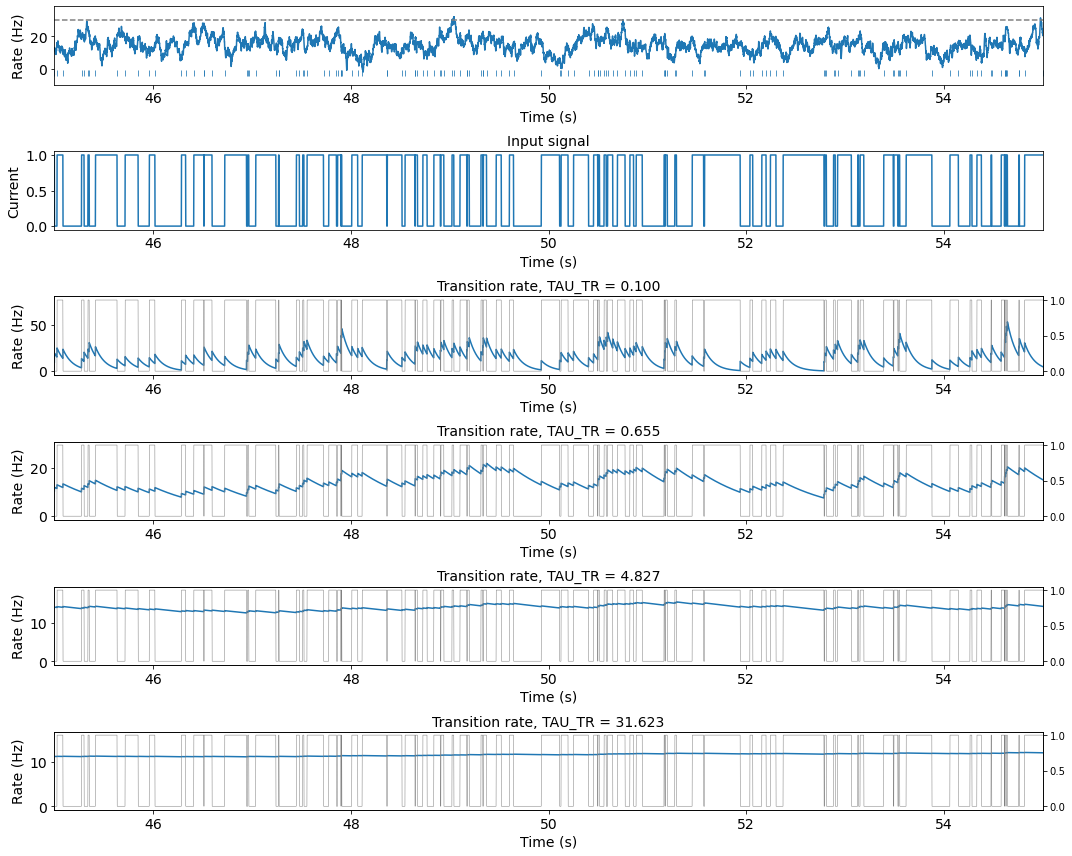

In [16]:
# generate time-varying transition rate signal
t = np.arange(NT)*DT

eta = 15 + 50*np.random.randn(NT)
r_tr = signal.fftconvolve(eta, H_ETA, mode='full')[-NT:]*DT
p_tr = DT*r_tr
tr = (np.random.rand(NT) < p_tr).astype(int)
tr[0] = 0  # no transitions in first timesteps

i = np.cumsum(tr).astype(float) % 2  # input

# estimated transition rates at different timescales
r_tr_est = np.nan*np.zeros((NT, NTAU_TR))
r_tr_est[0, :] = 0.

for ct in range(1, NT):
    r_tr_est[ct, :] = r_tr_est[ct-1, :] + (DT/TAU_TR)*(-r_tr_est[ct-1, :] + tr[ct])

r_tr_est /= DT

x_lim = (45, 55)
fig, axs = plt.subplots(6, 1, figsize=(15, 12), tight_layout=True)
axs[0].plot(t, r_tr)
axs[0].scatter(tr.nonzero()[0]*DT, -3*np.ones(tr.sum()), marker='|', lw=0.75)
axs[0].axhline(30, ls='--', color='gray')
    
set_plot(axs[0], x_lim=x_lim, x_label='Time (s)', y_label='Rate (Hz)', font_size=14)

axs[1].plot(t, i)
set_plot(axs[1], x_lim=x_lim, x_label='Time (s)', y_label='Current', title='Input signal', font_size=14)

idxs_tau_tr_plot = np.round(np.linspace(0, NTAU_TR-1, 4)).astype(int)
for idx, ax in zip(idxs_tau_tr_plot, axs[2:]):
    ax.plot(t, r_tr_est[:, idx])
    ax_twin = ax.twinx()
    ax_twin.plot(t, i, c='gray', lw=.5)
    
    set_plot(ax, x_lim=x_lim, x_label='Time (s)', y_label='Rate (Hz)', title=f'Transition rate, TAU_TR = {TAU_TR[idx]:.3f}', font_size=14)